In [1]:
%matplotlib inline

import os,sys,inspect

PATH = '/Users/francescogemignani/Desktop/fma-proj'
sys.path.insert(0, PATH) 


import pandas as pd
import numpy as np
from utility_functions import report
import seaborn as sns

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel

import plotly.express as px
import matplotlib.pyplot as plt
from fma_metadata import utils

import warnings
warnings.filterwarnings('ignore')

------------------
# Multi genre Classification
##  Librosa features
-------------------------

## 1. Data Preprocessing

In [ ]:
# Import features dataset
features = utils.load('/Users/francescogemignani/Google Drive/DM2/_FMA/fma_metadata/features.csv')
features.head()

In [3]:
# Import genre_labels dataset
labels = pd.read_csv('/Users/francescogemignani/Desktop/fma-proj/src/Data (cleaned)/genres_top')
labels=labels.set_index('track_id')
labels.head()

genre_top
track_id          
2          Hip-Hop
3          Hip-Hop
5          Hip-Hop
10             Pop
134        Hip-Hop

In [4]:
# Merging genre_top with librosa
features = features.merge(labels, on='track_id')
features.head()

(chroma_cens, kurtosis, 01)  (chroma_cens, kurtosis, 02)  \
track_id                                                             
2                            7.180653                     5.230309   
3                            1.888963                     0.760539   
5                            0.527563                    -0.077654   
10                           3.702245                    -0.291193   
134                          0.918445                     0.674147   

          (chroma_cens, kurtosis, 03)  (chroma_cens, kurtosis, 04)  \
track_id                                                             
2                            0.249321                     1.347620   
3                            0.345297                     2.295201   
5                           -0.279610                     0.685883   
10                           2.196742                    -0.234449   
134                          0.577818                     1.281117   

          (chroma_cens, kurtosis, 05)  (chroma_cens, kurtosis, 06)  \
track_id                                                             
2                            1.482478                     0.531371   
3                            1.654031                     0.067592   
5                            1.937570                     0.880839   
10                           1.367364                     0.998411   
134                          0.933746                     0.078177   

          (chroma_cens, kurtosis, 07)  (chroma_cens, kurtosis, 08)  \
track_id                                                             
2                            1.481593                     2.691455   
3                            1.366848                     1.054094   
5                           -0.923192                    -0.927232   
10                           1.770694                     1.604566   
134                          1.199204                    -0.175223   

          (chroma_cens, kurtosis, 09)  (chroma_cens, kurtosis, 10)  ...  \
track_id                                                            ...   
2                            0.866868                     1.341231  ...   
3                            0.108103                     0.619185  ...   
5                            0.666617                     1.038546  ...   
10                           0.521217                     1.982386  ...   
134                          0.925482                     1.438509  ...   

          (tonnetz, std, 05)  (tonnetz, std, 06)  (zcr, kurtosis, 01)  \
track_id                                                                
2                   0.012226            0.012111             5.758890   
3                   0.014212            0.017740             2.824694   
5                   0.012691            0.014759             6.808415   
10                  0.017952            0.013921            21.434212   
134                 0.016322            0.015819             4.731087   

          (zcr, max, 01)  (zcr, mean, 01)  (zcr, median, 01)  (zcr, min, 01)  \
track_id                                                                       
2               0.459473         0.085629           0.071289             0.0   
3               0.466309         0.084578           0.063965             0.0   
5               0.375000         0.053114           0.041504             0.0   
10              0.452148         0.077515           0.071777             0.0   
134             0.419434         0.064370           0.050781             0.0   

          (zcr, skew, 01)  (zcr, std, 01)  genre_top  
track_id                                              
2                2.089872        0.061448    Hip-Hop  
3                1.716724        0.069330    Hip-Hop  
5                2.193303        0.044861    Hip-Hop  
10               3.542325        0.040800        Pop  
134              1.806106        0.054623    Hip-Hop  

[5 rows x 519 columns]

In [5]:
# drop NaN
features.dropna(inplace=True)
features.isnull().sum()

(chroma_cens, kurtosis, 01)    0
(chroma_cens, kurtosis, 02)    0
(chroma_cens, kurtosis, 03)    0
(chroma_cens, kurtosis, 04)    0
(chroma_cens, kurtosis, 05)    0
                              ..
(zcr, median, 01)              0
(zcr, min, 01)                 0
(zcr, skew, 01)                0
(zcr, std, 01)                 0
genre_top                      0
Length: 519, dtype: int64

In [6]:
features.genre_top.value_counts()

Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: genre_top, dtype: int64

In [7]:
# Select top 8 genres
genres_subset = ['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic','Pop',
          'Classical','Jazz']

# generating dataset for multiclass classification task
feat_all = features[features['genre_top'].isin(genres_subset)]
feat_all.head()

(chroma_cens, kurtosis, 01)  (chroma_cens, kurtosis, 02)  \
track_id                                                             
2                            7.180653                     5.230309   
3                            1.888963                     0.760539   
5                            0.527563                    -0.077654   
10                           3.702245                    -0.291193   
134                          0.918445                     0.674147   

          (chroma_cens, kurtosis, 03)  (chroma_cens, kurtosis, 04)  \
track_id                                                             
2                            0.249321                     1.347620   
3                            0.345297                     2.295201   
5                           -0.279610                     0.685883   
10                           2.196742                    -0.234449   
134                          0.577818                     1.281117   

          (chroma_cens, kurtosis, 05)  (chroma_cens, kurtosis, 06)  \
track_id                                                             
2                            1.482478                     0.531371   
3                            1.654031                     0.067592   
5                            1.937570                     0.880839   
10                           1.367364                     0.998411   
134                          0.933746                     0.078177   

          (chroma_cens, kurtosis, 07)  (chroma_cens, kurtosis, 08)  \
track_id                                                             
2                            1.481593                     2.691455   
3                            1.366848                     1.054094   
5                           -0.923192                    -0.927232   
10                           1.770694                     1.604566   
134                          1.199204                    -0.175223   

          (chroma_cens, kurtosis, 09)  (chroma_cens, kurtosis, 10)  ...  \
track_id                                                            ...   
2                            0.866868                     1.341231  ...   
3                            0.108103                     0.619185  ...   
5                            0.666617                     1.038546  ...   
10                           0.521217                     1.982386  ...   
134                          0.925482                     1.438509  ...   

          (tonnetz, std, 05)  (tonnetz, std, 06)  (zcr, kurtosis, 01)  \
track_id                                                                
2                   0.012226            0.012111             5.758890   
3                   0.014212            0.017740             2.824694   
5                   0.012691            0.014759             6.808415   
10                  0.017952            0.013921            21.434212   
134                 0.016322            0.015819             4.731087   

          (zcr, max, 01)  (zcr, mean, 01)  (zcr, median, 01)  (zcr, min, 01)  \
track_id                                                                       
2               0.459473         0.085629           0.071289             0.0   
3               0.466309         0.084578           0.063965             0.0   
5               0.375000         0.053114           0.041504             0.0   
10              0.452148         0.077515           0.071777             0.0   
134             0.419434         0.064370           0.050781             0.0   

          (zcr, skew, 01)  (zcr, std, 01)  genre_top  
track_id                                              
2                2.089872        0.061448    Hip-Hop  
3                1.716724        0.069330    Hip-Hop  
5                2.193303        0.044861    Hip-Hop  
10               3.542325        0.040800        Pop  
134              1.806106        0.054623    Hip-Hop  

[5 rows x 519 columns]

In [8]:
feat_all.shape

(34596, 519)

In [9]:
pd.concat([feat_all.genre_top.value_counts(),
                round(feat_all.genre_top.value_counts(normalize=True).mul(100),2)],
          axis=1,
          keys=('counts','percentage (%)'))

counts  percentage (%)
Rock                  14182           40.99
Electronic             9372           27.09
Hip-Hop                3552           10.27
Folk                   2803            8.10
Pop                    2332            6.74
Classical              1230            3.56
Jazz                    571            1.65
Old-Time / Historic     554            1.60

In [10]:
# encoding labels
le = preprocessing.LabelEncoder()
feat_all['genre_top'] = le.fit_transform(feat_all['genre_top'])
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock')
feat_all.genre_top.value_counts()

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock


7    14182
1     9372
3     3552
2     2803
6     2332
0     1230
4      571
5      554
Name: genre_top, dtype: int64

In [11]:
# detach target col
labels = feat_all[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

In [12]:
feat_all.drop('genre_top', axis=1, inplace=True)

In [13]:
# normalize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feat_all)

# 2. PCA on normalized data
## 2.1 Determine optimal number of components
### a) screen-plot

Text(0.5, 0, 'Principal Component #')

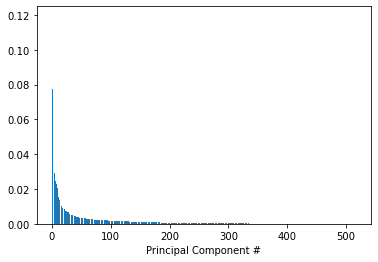

In [14]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

### b) cumulative explained variance plot

Optimal number of components: 152
Explained variation per principal component:
[1.19045918e-01 7.75472323e-02 4.09358743e-02 3.14708249e-02
 2.93193965e-02 2.59461346e-02 2.46854612e-02 2.37764997e-02
 2.28110193e-02 2.04168646e-02 1.78719788e-02 1.55423005e-02
 1.42070758e-02 1.39018382e-02 1.30138548e-02 1.16497565e-02
 1.03535566e-02 9.78742297e-03 9.35364858e-03 9.20689493e-03
 8.88709493e-03 8.27491225e-03 8.00739328e-03 7.58835894e-03
 7.26664910e-03 7.10596178e-03 6.89994324e-03 6.55399652e-03
 6.52770406e-03 6.30209263e-03 5.72200725e-03 5.55734011e-03
 5.41593903e-03 5.26538662e-03 5.11653837e-03 5.01000144e-03
 4.85771739e-03 4.77991602e-03 4.51631790e-03 4.44542856e-03
 4.42333617e-03 4.28092829e-03 4.04121013e-03 3.94219448e-03
 3.88860449e-03 3.74428489e-03 3.64467946e-03 3.60659547e-03
 3.53373031e-03 3.46182633e-03 3.43455869e-03 3.41878646e-03
 3.36796044e-03 3.25096181e-03 3.20614680e-03 3.16137148e-03
 3.10813525e-03 3.05675451e-03 2.97087625e-03 2.92969558e-03
 2.916

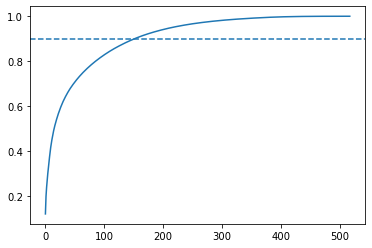

In [15]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)

# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=10)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)

## 2.2 Plot PCA in 2D

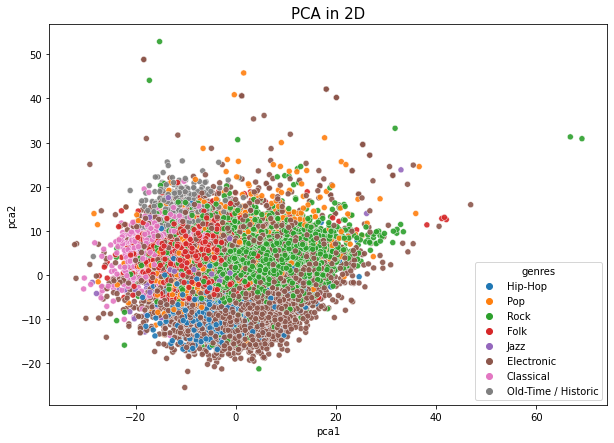

In [16]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2]
df['genres'] = le.inverse_transform(labels)

# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    data=df,
    legend="full",
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

### 2.3 Plot PCA in 3D

In [17]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    df, x='pca1', y='pca2', z='pca3', color='genres',
    #title=f'Total Explained Variance: {total_var:.2f}%',
    #labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.6
),width=700, height=700, scene_camera_eye_z=0.8)
fig.show()

# 3. Split data for classification

In [18]:
# shuffle and split into development set and internal test set:
# (PCA)
Xpca_develop, Xpca_test, y_develop_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=10)

# (no PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
scaled_features, labels, test_size=0.30, random_state=10)

In [19]:
# check partitions
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n\n***PCA***\nDevelopment set:\n{y_develop_pca.value_counts()}\n{len(y_develop_pca)}\n\nInternal Test:\
\n{y_test_pca.value_counts()}\n{len(y_test_pca)}\n\n\-----------------\n\***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n{len(y_develop)}\n\nInternal Test:\n{y_test.value_counts()}\n{len(y_test)}")



____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

***PCA***
Development set:
7    9961
1    6551
3    2503
2    1952
6    1616
0     857
5     390
4     387
Name: genre_top, dtype: int64
24217

Internal Test:
7    4221
1    2821
3    1049
2     851
6     716
0     373
4     184
5     164
Name: genre_top, dtype: int64
10379

\-----------------
\***No-PCA***
Development set:
7    9961
1    6551
3    2503
2    1952
6    1616
0     857
5     390
4     387
Name: genre_top, dtype: int64
24217

Internal Test:
7    4221
1    2821
3    1049
2     851
6     716
0     373
4     184
5     164
Name: genre_top, dtype: int64
10379


# 4. Decision Tree
### a) Unbalanced -  Features Selection
Features are selected based on importance weights.

In [20]:
sel = SelectFromModel(DecisionTreeClassifier())
X_develop_sel = sel.fit_transform(X_develop, y_develop)

In [21]:
print(f"Original number of features: {len(feat_all.columns)}\nAfter Feature Selector: {X_develop_sel.shape[1]}\nNumber of Features detached: {len(feat_all.columns)-X_develop_sel.shape[1]}")

Original number of features: 518
After Feature Selector: 113
Number of Features detached: 405


In [22]:
X_test_sel = sel.transform(X_test)

#### - Validation Schema: coarse grid-search with 5 fold CV
We adopt a 5 fold cross validation repeated 10 times and then averaged, in order to reduce the variance of the model.

In [23]:
# search parameters
param_grid = {
               "max_depth": [4,5,6,7,9,10],
               "min_samples_leaf": [10,15,20,25,35,45,50,55],
               "min_samples_split": [10,20,30,40,50],
               "criterion": ["gini"]
             }

# instantiate a model
dtc = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop_sel, y_develop)
# display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   31.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  5.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 11.3min
[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed: 19.8min finished


best parameters:
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 35, 'min_samples_split': 10}
accuracy: 0.6399636530918914
Model with rank: 1
Mean validation score: 0.640 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 35, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.640 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 35, 'min_samples_split': 20}

Model with rank: 1
Mean validation score: 0.640 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 35, 'min_samples_split': 30}

Model with rank: 1
Mean validation score: 0.640 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 35, 'min_samples_split': 40}

Model with rank: 1
Mean validation score: 0.640 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 35, 'min_samples_split': 50}



#### - Train and predict

In [27]:
# train and fit
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=9,min_samples_leaf= 35,min_samples_split=10)
dtc.fit(X_develop_sel,y_develop)
# predict on internal test set
y_pred_dtc = dtc.predict(X_test_sel)

# display metrics
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))


____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock

Accuracy 0.630118508526833
F1-score [0.61850444 0.62972045 0.49936789 0.4536301  0.         0.67532468
 0.02973978 0.7553941 ]
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       373
           1       0.58      0.68      0.63      2821
           2       0.54      0.46      0.50       851
           3       0.51      0.41      0.45      1049
           4       0.00      0.00      0.00       184
           5       0.72      0.63      0.68       164
           6       0.13      0.02      0.03       716
           7       0.71      0.81      0.76      4221

    accuracy                           0.63     10379
   macro avg       0.47      0.46      0.46     10379
weighted avg       0.58      0.63      0.60     10379



Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock



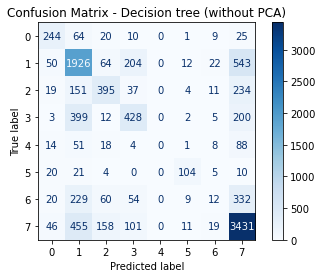

In [29]:
# confusion matrix - Internal Test
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm = plot_confusion_matrix(dtc,X_test_sel,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree')
#print(cm.confusion_matrix)
plt.show()

### b) Unbalanced - PCA
#### Validation schema:  repeated 5 fold cross validation - grid search

In [32]:
# model
dtc_pca = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
clf = GridSearchCV(dtc_pca, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)

clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   41.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 15.3min
[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed: 26.8min finished


best parameters:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 55, 'min_samples_split': 10}
accuracy: 0.6115541206092614
Model with rank: 1
Mean validation score: 0.612 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 55, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.612 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 55, 'min_samples_split': 20}

Model with rank: 1
Mean validation score: 0.612 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 55, 'min_samples_split': 30}

Model with rank: 1
Mean validation score: 0.612 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 55, 'min_samples_split': 40}

Model with rank: 1
Mean validation score: 0.612 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 55, 'min_samples_split': 50}



#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc_pca

The roc curve will be saved as:
- roc_auc1

The false and true positive rates will be saved as:
- fpr1
- tpr1

In [34]:
dtc_pca = DecisionTreeClassifier(criterion= 'entropy',max_depth=10, min_samples_leaf= 55,min_samples_split=10)
dtc_pca.fit(Xpca_develop,y_develop_pca)

y_pred_dtc_pca = dtc_pca.predict(Xpca_test)
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock

Accuracy 0.6100780422005974
F1-score [0.63453815 0.5969312  0.4453584  0.38074398 0.18181818 0.73981191
 0.03684211 0.74911972]
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       373
           1       0.56      0.64      0.60      2821
           2       0.45      0.45      0.45       851
           3       0.45      0.33      0.38      1049
           4       0.33      0.12      0.18       184
           5       0.76      0.72      0.74       164
           6       0.32      0.02      0.04       716
           7       0.70      0.81      0.75      4221

    accuracy                           0.61     10379
   macro avg       0.52      0.47      0.47     10379
weighted avg       0.58      0.61      0.58     10379



Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock



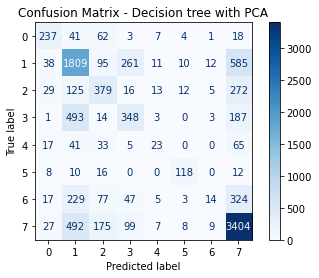

In [35]:
# confusion matrix Decision tree with PCA
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm_pca = plot_confusion_matrix(dtc_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree with PCA')
#print(cm_pca.confusion_matrix)
plt.show()

# 5. KNN
### a) Unbalanced - Features Selection
Features selection is performed using SelectKBest. <br>
The function used as a criteria for scoring the feature is the ANOVA F-value.

In [21]:
from sklearn.feature_selection import SelectKBest

In [22]:
sel = SelectKBest(k=50)
X_develop_sel = sel.fit_transform(X_develop, y_develop)
X_develop_sel.shape

(24217, 50)

In [23]:
X_test_sel = sel.transform(X_test)

#### - Validation schema: coarse grid search with repeated 5 fold cross validation

In [70]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2,50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_develop_sel, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

best parameters:
{'n_neighbors': 6}
accuracy: 0.6985175595447677
Model with rank: 1
Mean validation score: 0.699 (std: 0.007)
Parameters: {'n_neighbors': 6}

Model with rank: 2
Mean validation score: 0.698 (std: 0.007)
Parameters: {'n_neighbors': 8}

Model with rank: 3
Mean validation score: 0.698 (std: 0.007)
Parameters: {'n_neighbors': 7}



## - Train and predict

In [24]:
knn =  KNeighborsClassifier(n_neighbors = 6)
# retrain knn on the whole development set
knn.fit(X_develop_sel, y_develop)
# predict target variable
y_pred_knn = knn.predict(X_test_sel)

# display classification report
print(classification_report(y_test, y_pred_knn))
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')

              precision    recall  f1-score   support

           0       0.62      0.88      0.73       373
           1       0.69      0.69      0.69      2821
           2       0.60      0.62      0.61       851
           3       0.58      0.54      0.56      1049
           4       0.46      0.22      0.30       184
           5       0.85      0.93      0.89       164
           6       0.44      0.15      0.22       716
           7       0.78      0.85      0.81      4221

    accuracy                           0.70     10379
   macro avg       0.63      0.61      0.60     10379
weighted avg       0.68      0.70      0.68     10379

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock



#### - Confusion Matrix

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock



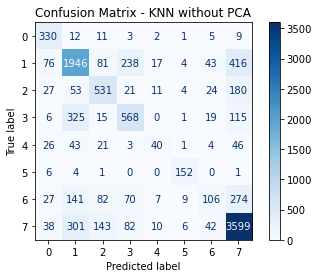

In [26]:
# confusion matrix KNN - Internal test
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock\n')
cm_knn = plot_confusion_matrix(knn,X_test_sel,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN')
#print(cm_knn.confusion_matrix)
plt.show()

### b) Unbalanced -  PCA
#### - Validation schema: coarse grid search with repeated 5 fold cross validation

In [29]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(Xpca_develop, y_develop_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

best parameters:
{'n_neighbors': 10}
accuracy: 0.6979601689584752


In [30]:
report(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.698 (std: 0.004)
Parameters: {'n_neighbors': 10}

Model with rank: 2
Mean validation score: 0.698 (std: 0.006)
Parameters: {'n_neighbors': 8}

Model with rank: 3
Mean validation score: 0.698 (std: 0.005)
Parameters: {'n_neighbors': 9}



#### - Train and predict

In [31]:
knn_pca =  KNeighborsClassifier(n_neighbors = 10)
# retrain knn on the whole development set
knn_pca.fit(Xpca_develop, y_develop_pca)
# predict target variable
y_pred_knn1 = knn_pca.predict(Xpca_test)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))

              precision    recall  f1-score   support

           0       0.72      0.86      0.78       373
           1       0.75      0.60      0.67      2821
           2       0.62      0.55      0.58       851
           3       0.59      0.59      0.59      1049
           4       0.50      0.32      0.39       184
           5       0.95      0.95      0.95       164
           6       0.38      0.08      0.13       716
           7       0.71      0.91      0.79      4221

    accuracy                           0.70     10379
   macro avg       0.65      0.61      0.61     10379
weighted avg       0.68      0.70      0.67     10379



#### - Confusion Matrix

[[ 320    6   17    2    3    0    1   24]
 [  37 1698   79  299   15    2   31  660]
 [  27   21  466   13    7    2   14  301]
 [   1  251    5  623    2    0    9  158]
 [  21   14   15    5   59    0    1   69]
 [   6    2    0    0    0  155    1    0]
 [  15  122   62   59    9    2   54  393]
 [  16  138  112   61   22    3   30 3839]]


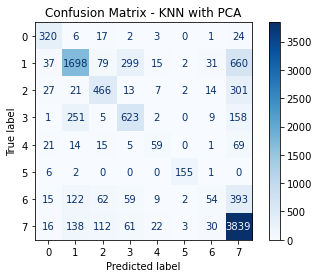

In [32]:
cm_knn_pca = plot_confusion_matrix(knn_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_knn_pca.ax_.set_title('Confusion Matrix  - KNN with PCA')
print(cm_knn_pca.confusion_matrix)